<a href="https://colab.research.google.com/github/HungryAmoeba/chess_analysis/blob/main/chess_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install PHATE. It may be necessary to restart the runtime after this
!pip install --user --upgrade phate scprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import chess.pgn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy

import pandas as pd
from matplotlib.pyplot import figure

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data import

Much of the code to convert PGN to one hot vectors is adapted from: https://medium.com/analytics-vidhya/analyzing-chess-positions-with-python-26d73b7c892

### Define functions

In [ ]:
lookup_fen = {
    'p': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'n': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'b': np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'r': np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'q': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'k': np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=bool),
    'P': np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=bool),
    'N': np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=bool),
    'B': np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=bool),
    'R': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=bool),
    'Q': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=bool),
    'K': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=bool),
}
# just reverse the dictionary and if a frame is all 12 zeros, set its item to none
lookup_hot = {tuple(value): key for key, value in lookup_fen.items()}
lookup_hot[tuple([False for _ in range(12)])] =  None

In [ ]:
def piecetovec(piece):
    return lookup_fen.get(piece, None)

def vectopiece(vec):
    return lookup_hot[tuple(vec)]

def fentohot(fen):
    iter = 0
    onehotboard = np.zeros((64, 12), dtype=bool)
    for p in fen:
        if p == ' ':
            break
        if p == '/':
            continue
        encoding = piecetovec(p)
        if encoding is not None:
            onehotboard[iter, :] = encoding
            iter = iter + 1
        else:
            iter = iter + int(p)

    return onehotboard

def hottofen(onehot):
    onehot = onehot.reshape((64,12))
    jter = 0
    fenboard = ''
    for iter in range(64):
        if iter % 8 == 0 and iter > 0:
            if jter > 0:
                fenboard += str(jter)
                jter = 0

            fenboard += '/'

        key = vectopiece(onehot[iter, :])

        if key is not None:
            if not jter == 0:
                fenboard += str(jter)
                jter = 0

            fenboard += key
        else:
            jter += 1

    if not jter == 0:
        fenboard += str(jter)
        jter = 0
    
    return fenboard

In [ ]:
# encode game results
results_dict = {
    '1-0': 1,
    '0-1': 2,
    '1/2-1/2': 3
}

### Run export and save

In [ ]:
positions = np.zeros((768, 100000), dtype=bool)
iter = 0

# keep track of elo of both players, and the game outcome
# also store FIDE player ID
elo_black = np.zeros(100000, dtype = np.short)
elo_white = np.zeros(100000, dtype = np.short)
FID_black = np.zeros(100000, dtype = np.int64)
FID_white = np.zeros(100000, dtype = np.int64)
game_num = np.zeros(100000, dtype = np.int64)
# 1 for white win, 2 for black win, 3 for draw
game_outcome = np.zeros(100000, dtype = np.short)
desired_tags = ['BlackElo', 'WhiteElo', 'BlackFideId', 'WhiteFideId', "Result"]

# Pulled games off of https://theweekinchess.com/twic
# tournament chess games

# load either TWIC data or hans games
game_number = 0
for jter in range(1440, 1464):
#for jter in range(0,12):
    print(jter)
    pgn = open(f'drive/MyDrive/Chess/twic{jter}.pgn')
    #pgn = open(f'drive/MyDrive/Chess/Hans/master_games ({jter}).pgn')
    while True:
        try:
            game = chess.pgn.read_game(pgn)
            game_number = game_number + 1
        except UnicodeDecodeError:
            print('Cannot decode game')
            continue
        
        if game is None:
            break

        board = game.board()
        contains_all = all([tag in game.headers.keys() for tag in desired_tags])
        # could check to make sure all headers are included here
        if contains_all:
          for move in game.mainline_moves():
              board.push(move)
              hot = fentohot(board.fen()).reshape((768,))
              #only record game_num
              positions[:,iter] = hot
              game_num[iter] = game_number
              #print(int(game.headers['WhiteFideId']))
              elo_black[iter] = int(game.headers['BlackElo'])
              elo_white[iter] = int(game.headers['WhiteElo'])
              FID_black[iter] = int(game.headers['BlackFideId'])
              FID_white[iter] = int(game.headers['WhiteFideId'])
              game_outcome[iter] = results_dict[game.headers['Result']]

              iter = iter + 1
              # if positions needs to be expanded, pad it
              if iter == positions.shape[1]: #change back to positions.shape[1] later
                  # Double array size to get amortized O(1) additions
                  positions = np.pad(positions, ((0, 0),(0, iter)), 'constant', constant_values=(None, 0))
                  elo_black = np.pad(elo_black, (0, iter), 'constant', constant_values=0)
                  elo_white = np.pad(elo_white, (0, iter), 'constant', constant_values=0)
                  FID_black = np.pad(FID_black, (0,iter), 'constant', constant_values=0)
                  FID_white = np.pad(FID_white, (0,iter), 'constant', constant_values=0)
                  game_outcome = np.pad(game_outcome, (0,iter), 'constant', constant_values=0)
                  game_num = np.pad(game_num, (0, iter), 'constant', constant_values=0)

# ignore zeros afterwards
positions = positions[:, 0:iter]
elo_black = elo_black[0:iter]
elo_white = elo_white[0:iter]
FID_black = FID_black[0:iter]
FID_white = FID_black[0:iter]
game_outcome = game_outcome[0:iter]
game_num = game_num[0:iter]

In [ ]:
# save one hot board positions to drive
np.save('drive/MyDrive/Chess/data/positions', positions)
np.save('drive/MyDrive/Chess/data/elo_black', elo_black)
np.save('drive/MyDrive/Chess/data/elo_white', elo_white)
np.save('drive/MyDrive/Chess/data/FID_black', FID_black)
np.save('drive/MyDrive/Chess/data/FID_white', FID_white)
np.save('drive/MyDrive/Chess/data/game_outcome', game_outcome)
np.save('drive/MyDrive/Chess/data/game_num', game_num)
# I don't think np save uses any compression, which would
# certainly be useful for these sparse vectors

In [ ]:
# save one hot board positions to drive
np.save('drive/MyDrive/Chess/data/hans_positions', positions)
np.save('drive/MyDrive/Chess/data/hans_elo_black', elo_black)
np.save('drive/MyDrive/Chess/data/hans_elo_white', elo_white)
np.save('drive/MyDrive/Chess/data/hans_FID_black', FID_black)
np.save('drive/MyDrive/Chess/data/hans_FID_white', FID_white)
np.save('drive/MyDrive/Chess/data/hans_game_outcome', game_outcome)
np.save('drive/MyDrive/Chess/data/hans_game_num', game_num)

## Preliminary data analysis

### Load and process full position data 

In [ ]:
# Download the data from the mounted drive

# DO NOT RUN THIS CELL OR ELSE TOO MUCH RAM WILL BE USED
# LOAD SHORT VERSIONS INSTEAD A FEW CELLS DOWN
positions = np.load('drive/MyDrive/Chess/data/positions.npy')
elo_black = np.load('drive/MyDrive/Chess/data/elo_black.npy')
elo_white = np.load('drive/MyDrive/Chess/data/elo_white.npy')
FID_black = np.load('drive/MyDrive/Chess/data/FID_black.npy')
FID_white = np.load('drive/MyDrive/Chess/data/FID_white.npy')
game_outcome = np.load('drive/MyDrive/Chess/data/game_outcome.npy')
game_num = np.load('drive/MyDrive/Chess/data/game_num.npy')

# first index is position number, second one is channels. (13 million, 768) after transpose
if positions.shape[0] == 768:
  positions = np.transpose(positions)

In [ ]:
# randomly sample 100000 points to serve as training for 
approx_n_points = 100000
rand_index = np.random.binomial(1, p = approx_n_points/len(elo_black), size = len(elo_black))

pos_short = np.array([positions[i] for i in np.where(rand_index)[0]])
elo_black_short = np.array([elo_black[i] for i in np.where(rand_index)[0]])
elo_white_short = np.array([elo_white[i] for i in np.where(rand_index)[0]])
FID_black_short = np.array([FID_black[i] for i in np.where(rand_index)[0]])
FID_white_short = np.array([FID_white[i] for i in np.where(rand_index)[0]])
game_outcome_short = np.array([game_outcome[i] for i in np.where(rand_index)[0]])
game_num_short = np.array([game_num[i] for i in np.where(rand_index)[0]])

n_points = len(elo_black_short)

np.save('drive/MyDrive/Chess/data/pos_short', pos_short)
np.save('drive/MyDrive/Chess/data/elo_black_short', elo_black_short)
np.save('drive/MyDrive/Chess/data/elo_white_short', elo_white_short)
np.save('drive/MyDrive/Chess/data/FID_black_short', FID_black_short)
np.save('drive/MyDrive/Chess/data/FID_white_short', FID_white_short)
np.save('drive/MyDrive/Chess/data/game_outcome_short', game_outcome_short)
np.save('drive/MyDrive/Chess/data/game_num_short', game_num_short)

### Perform operations on shortened dataset

In [ ]:
pos_short = np.load('drive/MyDrive/Chess/data/pos_short.npy')
elo_black_short = np.load('drive/MyDrive/Chess/data/elo_black_short.npy')
elo_white_short = np.load('drive/MyDrive/Chess/data/elo_white_short.npy')
FID_black_short = np.load('drive/MyDrive/Chess/data/FID_black_short.npy')
FID_white_short = np.load('drive/MyDrive/Chess/data/FID_white_short.npy')
game_outcome_short = np.load('drive/MyDrive/Chess/data/game_outcome_short.npy')
game_num_short = np.load('drive/MyDrive/Chess/data/game_num_short.npy')

if pos_short.shape[0] == 768:
  pos_short = np.transpose(pos_short)

In [ ]:
hans_positions = np.load('drive/MyDrive/Chess/data/hans_positions.npy')
hans_elo_black = np.load('drive/MyDrive/Chess/data/hans_elo_black.npy')
hans_elo_white = np.load('drive/MyDrive/Chess/data/hans_elo_white.npy')
hans_FID_black = np.load('drive/MyDrive/Chess/data/hans_FID_black.npy')
hans_FID_white = np.load('drive/MyDrive/Chess/data/hans_FID_white.npy')
hans_game_outcome = np.load('drive/MyDrive/Chess/data/hans_game_outcome.npy')
hans_game_num = np.load('drive/MyDrive/Chess/data/hans_game_num.npy')

if hans_positions.shape[0] == 768:
  hans_positions = np.transpose(hans_positions)

hans_FID = 2093596

### Basic data analysis

In [ ]:
print(f"Total number of games is {int(game_num[-1])}")
print(f"Average game length is {round(positions.shape[0]/game_num[-1]/2)}")

Total number of games is 157068
Average game length is 42


In [ ]:
from scipy import stats

# what is the length of the longest game?
m = stats.mode(game_num)
m 

ModeResult(mode=array([8204]), count=array([429]))

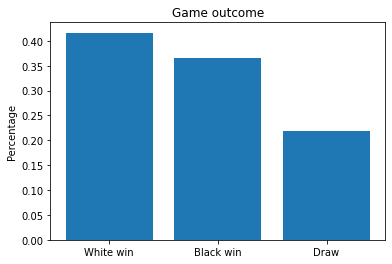

In [ ]:
data = {'White win': np.mean(game_outcome == 1), 'Black win': np.mean(game_outcome == 2), 'Draw': np.mean(game_outcome == 3)}
names = list(data.keys())
values = list(data.values())
fig, axs = plt.subplots()
axs.bar(names, values)
plt.ylabel("Percentage")
plt.title("Game outcome")
fig.show()

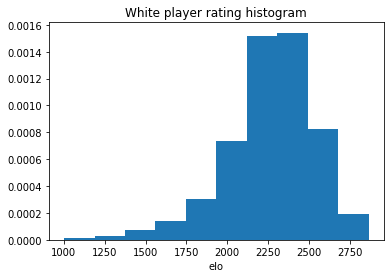

In [ ]:
plt.hist(elo_white, density = True)
plt.title("White player rating histogram")
plt.xlabel("elo")
plt.show()

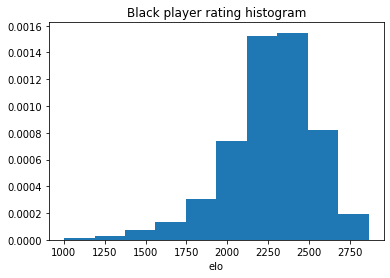

In [ ]:
plt.hist(elo_black, density = True)
plt.title("Black player rating histogram")
plt.xlabel("elo")
plt.show()

### PCA

In [ ]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


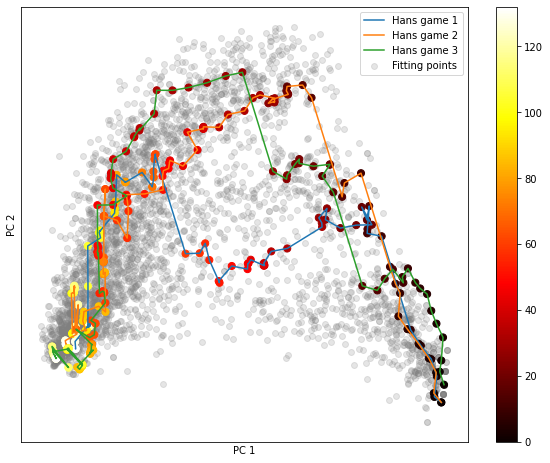

In [ ]:
# try at embedding chess games using PCA

import numpy as np
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure

figure(figsize=(10,8))
pca = PCA(n_components = 2)

# note that this is for when positions
assert(pos_short.shape[1] == 768)

pca.fit(pos_short)
n_points = 4000
ps = pca.fit_transform(pos_short)
#plt.scatter(ps[:,0][game_outcome_short == 1], ps[:,1][game_outcome_short == 1], label = 'White win', alpha = .2)
#plt.scatter(ps[:,0][game_outcome_short == 2], ps[:,1][game_outcome_short == 2], label = 'Black win', alpha = .2)
#plt.scatter(ps[:,0][game_outcome_short == 3], ps[:,1][game_outcome_short == 3], label = 'Draw', alpha = .2)
plt.scatter(ps[0:n_points,0], ps[0:n_points, 1], alpha = .2, label = 'Fitting points', c = 'grey')


# arbitrarily choose a hans game to plot

for game_num in range(1,4):
  hans_game = pca.transform(hans_positions[hans_game_num == game_num])
  plt.scatter(hans_game[:,0], hans_game[:,1], s = 50, c = list(range(len(hans_game))), cmap = 'hot') # cool or spring cmaps also look pretty decent
  plt.plot(hans_game[:,0], hans_game[:,1], label = f'Hans game {game_num}')
# for test_points in test_pointz:
#   plt.plot((ps[:,0][test_points], ps[:,1][test_points]), (), test_points)

#game_2 = [i > 111 and i < 300 for i in range(len(ps))]
#plt.plot(ps[:,0][game_2], ps[:,1][game_2])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([]); plt.yticks([])
plt.legend()
plt.colorbar()
plt.show()



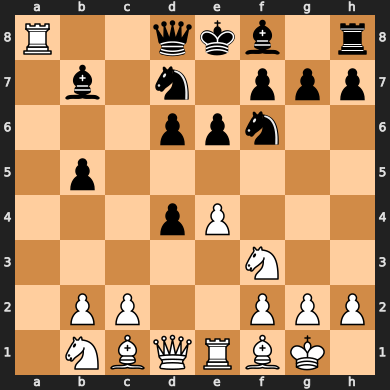

In [ ]:
pgn = hottofen(hans_positions[20,:])
chess.Board(pgn)

## TODO

Geometry regularized autoencoder

1.   Reconstruction loss alone
2.   Contrastive loss where we use the game outcome as the label
3.   Loss penalty based on the strength of the players
4.   Any combinations of the above
5.   Look at the size of the embedding layer. i.e. have a 10 dimensional embedding and then use PHATE to project it down into 2 dimension for visualization

b_0, b_1, b_2, b_3, ... b_n

f(b_0), f(b_1), ... maps out some trajectory in latent space

also could ask questions about the curvature of these points in embedding space
also see if we can see if a move is good


## Feature engineering

In [ ]:
positions.shape
# eventually do we want to try and make this into something 
# that's 8 x 8 x 12 and treat it as a 12 channel image?

NameError: ignored

In [ ]:
flat_prob = np.mean(positions, (1,))
flat_sum = np.sum(positions, (1,))
positionprob = np.mean(positions, (1,)).reshape(64,12)

ValueError: ignored

In [ ]:
piece_lookup = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5, 'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11}
file_lookup = {'a': 7, 'b': 6, 'c': 5, 'd': 4, 'e': 3, 'f': 2, 'g': 1, 'h': 0}
# this file lookup is very unintuitive... but oh well


def index_of(piece, file, rank):
    board_offset = rank*8 + file_lookup[file]
    piece_offset = piece_lookup[piece]
    return (64-board_offset)*12 - (12 - piece_offset)

In [ ]:
piece = ['p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']*8*8
file = [r for _ in range(8) for r in 'abcdefgh' for _ in range(12) ]
rank = [f for f in range(8) for _ in range(12) for _ in range(8) ]

index = [index_of(p, f, r) for (p, f, r) in zip(piece, file, rank)]
probability = [flat_prob[ind] for ind in index]
count = [flat_sum[ind] for ind in index]

df = pd.DataFrame.from_dict({
    'piece': piece,
    'file': file,
    'rank': [r+1 for r in rank],
    'index': index,
    'probability': probability,
    'count': count})

NameError: ignored

In [ ]:
pd.set_option('display.max_rows', 768)
df = df.sort_values(by='probability')
# to save the positions
# df.to_csv('./positions.csv')

Text(0.5, 1.0, 'Histogram of Piece-Position Probabilities')

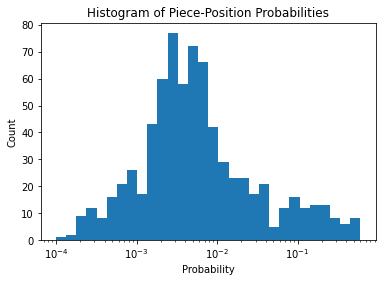

In [ ]:
x = positionprob.flatten()
hist, bins = np.histogram(x, bins=30)
logbins = np.logspace(np.log10(1e-4), np.log10(.60), len(bins))
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Histogram of Piece-Position Probabilities')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


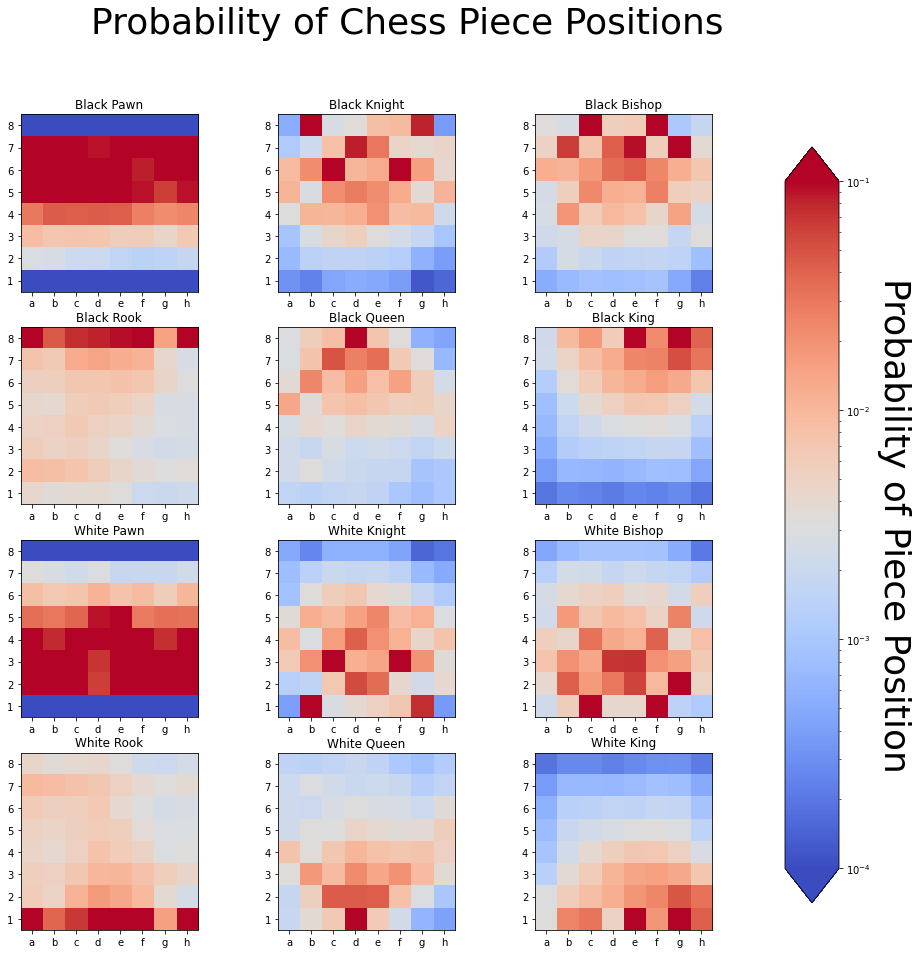

In [ ]:
title_lookup = {'p': 'Pawn', 'n': 'Knight', 'b': 'Bishop', 'r': 'Rook', 'q': 'Queen', 'k': 'King'}


file_tick = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
rank_tick = range(8,0,-1)

norm = colors.LogNorm(vmin=1e-4, vmax=1e-1) 
cmap = copy.copy(matplotlib.cm.get_cmap('coolwarm'))
cmap.set_bad(cmap(0))

fig, ax = plt.subplots(4,3)
fig.set_figheight(15)
fig.set_figwidth(15)

iter = 0
for key in piece_lookup:
    this_ax = ax[np.unravel_index(iter, (4,3))]
    iter = iter+1
    
    color = 'Black' if (key.islower()) else 'White'
    
    title = color + ' ' + title_lookup[key.lower()]
    
    to_show = positionprob[:,piece_lookup[key]].reshape(8,8)

    im = this_ax.imshow(to_show, cmap=cmap, norm=norm)
    this_ax.set_xticks(np.arange(len(file_tick)))
    this_ax.set_yticks(np.arange(len(rank_tick)))
    this_ax.set_xticklabels(file_tick)
    this_ax.set_yticklabels(rank_tick)
    
    this_ax.set_title(title)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

cbar = fig.colorbar(im, cax=cbar_ax, extend='both')
cbar.set_label('Probability of Piece Position', rotation=270, fontsize=36, labelpad=40)
cbar.minorticks_on()

fig.suptitle('Probability of Chess Piece Positions', fontsize=36)
plt.savefig('drive/MyDrive/Chess/chess_piece_position.jpg')
plt.show()


## Autoencoder
 

In [ ]:
import torch 
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else"cpu")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 14 15:16:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |   3124MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pos_short.dtype

dtype('bool')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
if pos_short.shape[0] == 768:
  pos_short = np.transpose(pos_short)

pos_short = torch.tensor(pos_short.astype(np.float32)) 
game_outcome_short = torch.tensor(game_outcome_short.astype(np.int32))

train_pos, test_pos = train_test_split(pos_short, test_size = .2, random_state=42)
train_lab, test_lab = train_test_split(game_outcome_short, test_size = .2, random_state=42)

chess_train_data = TensorDataset(train_pos, train_lab)
train_data = DataLoader(chess_train_data, batch_size = 32, shuffle = True)

chess_test_data = TensorDataset(test_pos, test_lab)
test_data = DataLoader(chess_test_data, batch_size = 32, shuffle = True)

#train_data = DataLoader(positions[0:math.floor(positions.shape[0] * train_frac), :].astype(np.float32), batch_size = 64)
# full_train_data = positions[0:train_size, :].astype(np.float32)
# validation_data = positions[train_size:train_size + validation_size, :].astype(np.float32)
# test_data = positions[train_size + validation_size: train_size + validation_size + test_size, :].astype(np.float32)

In [ ]:
for data, label in train_data:
  print(data.shape)
  print(label)

In [ ]:
import torch.nn as nn

in_data_shape = 768
class Autoencoder(nn.Module): 
    def __init__(self, embedding_dim):
        super().__init__() 
        self.layer1 = nn.Linear(in_data_shape,300) 
        self.layer2 = nn.Linear(300,100) 
        self.layer3 = nn.Linear(100,35) 
        self.layer4 = nn.Linear(35,embedding_dim) 
        self.nonlin = nn.ReLU()
        self.layer5 = nn.Linear(embedding_dim, 35)
        self.layer6 = nn.Linear(35, 100)
        self.layer7 = nn.Linear(100, 300)
        self.layer8 = nn.Linear(300, in_data_shape)
        # self.softmax = nn.Softmax() # Converts numbers into probabilities
    def encode(self,x):
        x = self.layer1(x) # Composing the functions we created below
        x = self.nonlin(x)
        x = self.layer2(x)
        x = self.nonlin(x)
        x = self.layer3(x)
        x = self.nonlin(x)
        x = self.layer4(x)
        return x
    def decode(self,x):
        x = self.layer5(x)
        x = self.nonlin(x)
        x = self.layer6(x)
        x = self.nonlin(x)
        x = self.layer7(x)
        x = self.nonlin(x)
        x = self.layer8(x)
        #x = self.nonlin(x)
        return x
    def forward(self, input):
        z = self.encode(input)
        y = self.decode(z)
        return y

In [ ]:
# Your loss function here
loss_fcn = nn.CrossEntropyLoss() ## is MSE better?


from tqdm.notebook import trange, tqdm

In [ ]:
def get_accuracy(output, targets):
    output = output.detach() # this removes the gradients associated with the tensor
    predicted = output.argmax(-1)
    correct = (predicted == targets).sum().item()
    accuracy = correct / output.size(0) * 100
    return accuracy
def plot_accuracies_and_loss(train_accs, test_accs, losses):
    fig, ax = plt.subplots(1,2)
    ax[0].plot(train_accs, marker='', color='skyblue', linewidth=2,label="Training Accuracy")
    ax[0].plot(test_accs, marker='', color='olive', linewidth=2,label="Testing Accuracy")
    ax[0].legend()
    ax[0].set_title("Accuracies")
    ax[1].set_title("Loss")
    ax[1].plot(losses, marker='', color='green', linewidth=2, label="Loss")
    plt.show()


  0%|          | 0/101 [00:00<?, ?it/s]

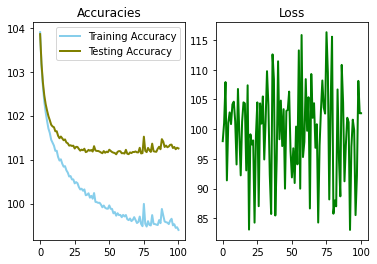

In [ ]:
ae = Autoencoder(2)  # the 2 specifies that the embedding dimension is 2
ae.to(device) 
opt = torch.optim.Adam(ae.parameters(), lr=0.0005, weight_decay = 1e-5) 
train_accs, test_accs, losses = [], [], [] 
for e in trange(101): 
    ae.train()
    for position, outcome in train_data:
        position = position.to(device) 
        #labels = labels.to(device)
        y = ae(position) 
        l = loss_fcn(y,position)
        l.backward()
        opt.step() 
        opt.zero_grad() 
    ae.eval() 

    train_ep_pred = ae(train_pos.to(device))
    test_ep_pred = ae(test_pos.to(device))
    # # run the model on the test set and get the loss
    train_loss = loss_fcn(train_ep_pred.cpu(), train_pos)
    test_loss = loss_fcn(test_ep_pred.cpu(), test_pos)

    train_accs.append(train_loss.detach().numpy())
    test_accs.append(test_loss.detach().numpy())
    losses.append(l.detach().cpu())
    
    #if e % 100 == 0:
        #print(f"Training Accuracy: {train_accuracy} - Test Accuracy: {test_accuracy}")
         # Visualize some images and their reconstruction
        
plot_accuracies_and_loss(train_accs, test_accs, losses)

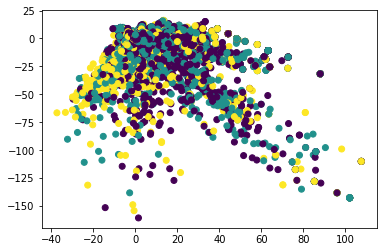

In [ ]:
# visualize the embedding

#tps = torch.tensor(test_data).to(device)
encoding = ae.encode(test_pos.to(device))
encoding = encoding.detach().cpu().numpy()
plt.scatter(encoding[:,0], encoding[:,1], c = test_lab)
plt.show()

## Autoencoder with PHATE

The purpose of this section is to explore what happens when the embedding dimension is greater than 2, say something like 10. Then to visualize the embedding, PHATE is used

In [ ]:
# install PHATE. It may be necessary to restart the runtime after this
!pip install --user --upgrade phate scprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 2.2 MB/s 
     |████████████████████████████████| 45 kB 1.8 MB/s 
     |████████████████████████████████| 419 kB 56.4 MB/s 
     |████████████████████████████████| 1.8 MB 72.6 MB/s 


In [ ]:
import phate

  0%|          | 0/101 [00:00<?, ?it/s]

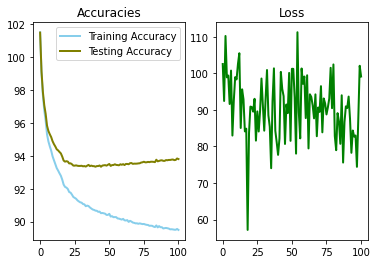

In [ ]:
# make the autoencoder model

ae_10 = Autoencoder(10)  # embedding dimension of 10
ae_10.to(device) 
opt = torch.optim.Adam(ae.parameters(), lr=0.0005, weight_decay = 1e-5) 
train_accs, test_accs, losses = [], [], [] 
for e in trange(101): 
    ae_10.train()
    for position, outcome in train_data:
        position = position.to(device) 
        #labels = labels.to(device)
        y = ae_10(position) 
        l = loss_fcn(y,position)
        l.backward()
        opt.step() 
        opt.zero_grad() 
    ae_10.eval() 

    train_ep_pred = ae_10(train_pos.to(device))
    test_ep_pred = ae_10(test_pos.to(device))
    # # run the model on the test set and get the loss
    train_loss = loss_fcn(train_ep_pred.cpu(), train_pos)
    test_loss = loss_fcn(test_ep_pred.cpu(), test_pos)

    train_accs.append(train_loss.detach().numpy())
    test_accs.append(test_loss.detach().numpy())
    losses.append(l.detach().cpu())
    
    #if e % 100 == 0:
        #print(f"Training Accuracy: {train_accuracy} - Test Accuracy: {test_accuracy}")
         # Visualize some images and their reconstruction
        
plot_accuracies_and_loss(train_accs, test_accs, losses)

In [ ]:
# generate embedded points
n_points_visual = 4000 
embed = ae_10.encode(test_pos[0:n_points_visual, :].to(device))
embed = np.array(embed.detach().cpu())

In [ ]:
# visualize using PHATE
phate_operator = phate.PHATE(n_jobs=-2)
Y_phate = phate_operator.fit_transform(embed)

Calculating PHATE...
  Running PHATE on 4000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.24 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.30 seconds.
  Calculating landmark operator...
    Calculating SVD...


/root/.local/lib/python3.8/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 868 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/root/.local/lib/python3.8/site-packages/graphtools/graphs.py:451: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 0.39 seconds.
    Calculating KMeans...
    Calculated KMeans in 11.31 seconds.
  Calculated landmark operator in 12.66 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 4.44 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.22 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.77 seconds.
Calculated PHATE in 24.44 seconds.


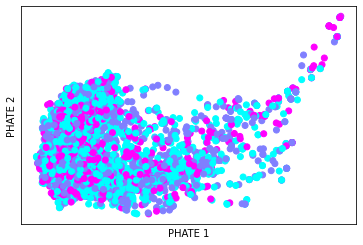

In [ ]:
plt.scatter(Y_phate[:,0], Y_phate[:,1], c = game_outcome_short[0:n_points_visual] + 1, cmap = "cool")
plt.xticks([]); plt.yticks([]);
plt.xlabel("PHATE 1"); plt.ylabel("PHATE 2")
plt.show()

## Contrastive Autoencoder

In [ ]:
# Rejigger dataloader to have 2 elements which are images from the same class a la pset 3
def split_by_vals(x):
    # Given a list with n types of distinct values, return a list `split_groups` with n sublists of indices such that x[split_groups[i]] contains only the ith value
    idxs = torch.argsort(x).tolist()
    split_groups = []
    i = 0
    while i < len(x):
        split_groups.append([idxs[i]])
        cur = x[idxs[i]]
        i += 1
        while i < len(x) and x[idxs[i]] == cur:
            split_groups[-1].append(idxs[i])
            i += 1
    return split_groups

In [ ]:
split_indices = split_by_vals(chess_train_data.tensors[1])
# create lists of each class of digit
image_classes = [chess_train_data.tensors[0][s] for s in split_indices]
label_classes = [chess_train_data.tensors[1][s] for s in split_indices]
# form batches by concatenating two of each type of image
minlen = min([len(x) for x in label_classes])
if minlen % 2 != 0:
  minlen -= 1
image_classes_deux, label_classes_deux = [], []
for i in range(len(image_classes)):
    image_classes_deux.extend([image_classes[i][:minlen//2][:,None,:],image_classes[i][minlen//2:minlen][:,None,:]]) # discard images until each class has the same number
    label_classes_deux.extend([label_classes[i][:minlen//2],label_classes[i][minlen//2:minlen]])
well_ordered_images = torch.column_stack(image_classes_deux)
well_ordered_labels = torch.column_stack(label_classes_deux)
# Shuffle while preserving the groups of two within each batch
import numpy as np
shuffled_idxs = list(range(3))
for i in range(well_ordered_images.shape[0]):
    np.random.shuffle(shuffled_idxs)
    by_twos = 2*np.repeat(shuffled_idxs,2) + (np.column_stack([np.zeros_like(shuffled_idxs),np.ones_like(shuffled_idxs)])).flatten()
    well_ordered_images[i] = well_ordered_images[i][by_twos]
    well_ordered_labels[i] = well_ordered_labels[i][by_twos]
print(well_ordered_images.shape)
print(well_ordered_labels.shape)
# compress back down to a single representation 
well_ordered_images = well_ordered_images.flatten(0,1)
well_ordered_labels = well_ordered_labels.flatten()
# create trainloader
contrastive_train_dataset = torch.utils.data.TensorDataset(well_ordered_images,well_ordered_labels)
contrastive_trainloader = torch.utils.data.DataLoader(
    contrastive_train_dataset, batch_size=6, shuffle=False
)

torch.Size([8805, 6, 768])
torch.Size([8805, 6])


In [ ]:
mse = nn.MSELoss()
sim = nn.CosineSimilarity(dim = 1, eps = 1e-6)

#sim = nn.MSELoss()
contrastive_rel_weight = 1
def contrastive_loss(y, images, embeddings, labels, embedding_length, embedding_dim):
  mse_loss = mse(y, images)
  numerator = torch.exp( sim(embeddings[0].reshape(1,embedding_dim), embeddings[1].reshape(1,embedding_dim)) )
  denominator = torch.sum( torch.exp( sim(embeddings[0].view(-1).repeat(embedding_length-2 ,1), embeddings[2: ].view(embedding_length-2, -1) ) ) )
  contrastive_loss = - torch.log( numerator/denominator )
  return mse_loss + contrastive_rel_weight * contrastive_loss

In [ ]:
embedding_dim = 10
ae_10_contrastive = Autoencoder(embedding_dim)
ae_10_contrastive.to(device) 
opt = torch.optim.Adam(ae.parameters(), lr=0.0005, weight_decay = 1e-5) 
train_accs, test_accs, losses = [], [], [] 
for e in trange(101): 
    ae_10_contrastive.train()
    for position, outcome in contrastive_trainloader:
        position = position.to(device) 
        #labels = labels.to(device)
        outcome = outcome.to(device)
        embed = ae_10_contrastive.encode(position)
        y = ae_10_contrastive.decode(embed) 
        l = contrastive_loss(y,position, embed, outcome, len(embed), embedding_dim)
        l.backward()
        opt.step() 
        opt.zero_grad() 
    ae_10_contrastive.eval() 

    #embed_train_ep_pred = ae_10_contrastive.encode(train_pos.to(device))
    #train_ep_pred = ae_10_contrastive.decode(embed_train_ep_pred)
    #test_ep_pred = ae_10_contrastive(test_pos.to(device))
    # # run the model on the test set and get the loss
    #train_loss = contrastive_loss(train_ep_pred, train_pos.to(device), embed_train_ep_pred, )
    #test_loss = loss_fcn(test_ep_pred.cpu(), test_pos)

    #train_accs.append(train_loss.detach().cpu().numpy())
    #test_accs.append(test_loss.detach().numpy())
    losses.append(l.detach().cpu())
    
    #if e % 100 == 0:
        #print(f"Training Accuracy: {train_accuracy} - Test Accuracy: {test_accuracy}")
         # Visualize some images and their reconstruction
        
plot_accuracies_and_loss(train_accs, test_accs, losses)

In [ ]:
# save the trained model
from datetime import date
today = date.today()
d1 = today.strftime("%m_%d_%Y")
save_path = f'drive/MyDrive/Chess/models/contrastive_ae_10_{d1}'
torch.save(ae_10_contrastive, save_path)

In [ ]:
ae_10_contrastive = torch.load('drive/MyDrive/Chess/models/contrastive_ae_10_12_14_2022')

In [ ]:
n_points_visual = 4000 

encoding = ae_10_contrastive.encode(train_pos.to(device))
encoding = encoding.detach().cpu().numpy()
# visualize using PHATE
phate_op = phate.PHATE(n_jobs=-2)
Y_phate = phate_op.fit_transform(encoding)

plt.scatter(Y_phate[0:n_points_visual,0], Y_phate[0:n_points_visual,1], c = game_outcome_short[0:n_points_visual] + 1, cmap = "cool")
plt.xticks([]); plt.yticks([]);
plt.xlabel("PHATE 1"); plt.ylabel("PHATE 2")
plt.show()

Calculating PHATE...
  Running PHATE on 80366 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 83.78 seconds.
    Calculating affinities...


/root/.local/lib/python3.8/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 67260 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/root/.local/lib/python3.8/site-packages/graphtools/graphs.py:451: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 4.77 seconds.
  Calculated graph and diffusion operator in 88.69 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 11.06 seconds.
    Calculating KMeans...


In [ ]:
game = torch.tensor(hans_positions[hans_game_num == game_num].astype(np.float32))
print(game.shape)
ae_10_contrastive.encode(game[0].to(device))

torch.Size([81, 768])


tensor([ 0.0143, -0.1218,  0.1290,  0.0915,  0.0165,  0.0421,  0.0844,  0.0118,
        -0.0519,  0.0664], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
train_pos[0].shape

torch.Size([768])

In [ ]:
ae_10_contrastive.encode(train_pos[0].to(device)).shape

torch.Size([10])

Calculating KNN search...
Calculated KNN search in 0.09 seconds.
Calculating affinities...


/root/.local/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...


/root/.local/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculating KNN search...


/root/.local/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 0.27 seconds.
Calculating affinities...
Calculated affinities in 0.03 seconds.


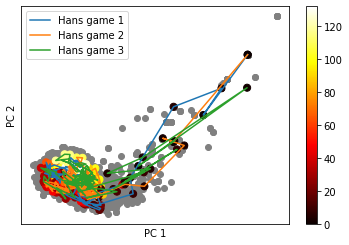

In [ ]:
# add some of hans games to the above plot
# arbitrarily choose a hans game to plot
plt.scatter(Y_phate[0:n_points_visual,0], Y_phate[0:n_points_visual,1], c = 'grey')
plt.xticks([]); plt.yticks([]);
plt.xlabel("PHATE 1"); plt.ylabel("PHATE 2")

for game_num in range(1,4):
  game = torch.tensor(hans_positions[hans_game_num == game_num].astype(np.float32))
  game_embed = ae_10_contrastive.encode(game.to(device)).detach().cpu().numpy()
  hans_game = phate_op.transform(game_embed)
  plt.scatter(hans_game[:,0], hans_game[:,1], s = 50, c = list(range(len(hans_game))), cmap = 'hot') # cool or spring cmaps also look pretty decent
  plt.plot(hans_game[:,0], hans_game[:,1], label = f'Hans game {game_num}')
# for test_points in test_pointz:
#   plt.plot((ps[:,0][test_points], ps[:,1][test_points]), (), test_points)

#game_2 = [i > 111 and i < 300 for i in range(len(ps))]
#plt.plot(ps[:,0][game_2], ps[:,1][game_2])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([]); plt.yticks([])
plt.legend()
plt.colorbar()
plt.show()

## TODOS

Change the embedding into higher dimension and then use PHATE to project into 2D
https://github.com/KrishnaswamyLab/PHATE -- Charles

Implement contrastive loss to show win/lose information -- Peter

Look into math of PHATE and see the effect of PHATE projecting into 2D vs embedding directly into 2D -- Madelyn 

Player style. Characterize trajectories in embedding space to understand style? -- Ziyu 




